In [25]:
import pandas as pd
import numpy as np

from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

register_matplotlib_converters()

In [4]:
data = pd.read_csv('data/dataset_task2.csv')

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute
data['DayOfWeek'] = data['date'].dt.dayofweek

data['shift_1d_IDA1'] = data['IDA1price'].shift(96).dropna()
data['shift_1w_IDA1'] = data['IDA1price'].shift(96*7).dropna()

data['shift_1d'] = data['IDA2price'].shift(96).dropna()
data['shift_1w'] = data['IDA2price'].shift(96*7).dropna()

holidays_map = {holiday: i for i, holiday in enumerate(data['holiday'].unique())}
data['holiday'] = data['holiday'].map(holidays_map)

data = data.dropna()

data.index = data['date']
data.drop(columns='date', inplace=True)
# data = data.iloc[:-24*4*2, :] # za pred
data

,forecast_production,production,forecast_consumption,consumption,holiday,da_load,IDA1price,IDA2price,SIPXprice,price,volumes,hour,minute,DayOfWeek,shift_1d_IDA1,shift_1w_IDA1,shift_1d,shift_1w
date,,,,,,,,,,,,,,,,,,
2024-06-22 00:00:00,1799.0,1899.0,1139.0,1150.0,1,1241.0,90.54,200.0,114.62,114.62,2021.7,0,0,5,112.99,46.60,133.87,80.93
2024-06-22 00:15:00,1799.0,1899.0,1139.0,1150.0,1,1241.0,121.60,200.0,114.62,114.62,2021.7,0,15,5,101.06,97.12,118.59,73.73
2024-06-22 00:30:00,1799.0,1899.0,1139.0,1150.0,1,1241.0,122.55,200.0,114.62,114.62,2021.7,0,30,5,112.58,97.12,105.00,61.94
2024-06-22 00:45:00,1799.0,1899.0,1139.0,1150.0,1,1241.0,75.79,200.0,114.62,114.62,2021.7,0,45,5,114.41,97.12,94.14,46.49
2024-06-22 01:00:00,1799.0,1899.0,1076.0,1093.0,1,1183.0,135.00,200.0,106.14,106.14,2105.0,1,0,5,109.85,36.10,118.66,68.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-12 22:45:00,1600.0,2370.0,1486.0,1647.0,1,1591.0,111.25,0.0,128.47,128.47,1409.4,22,45,1,108.00,92.35,101.42,103.77
2024-11-12 23:00:00,1451.0,2370.0,1383.0,1647.0,1,1492.0,149.95,0.0,118.31,118.31,1308.7,23,0,1,137.70,132.49,143.11,130.46
2024-11-12 23:15:00,1451.0,2370.0,1383.0,1647.0,1,1492.0,123.48,0.0,118.31,118.31,1308.7,23,15,1,117.20,110.00,125.06,103.30


In [5]:
X = data[['hour', 'minute', 'IDA1price', 'volumes', 'forecast_production', 'SIPXprice', 'da_load',
		  'shift_1d', 'shift_1w', 'forecast_consumption', 'DayOfWeek', 'holiday', 'shift_1d_IDA1']]
y = data['IDA2price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

# Final prediction
# split_date = '2024-11-12'  # Change this to your desired date if needed
# X_train = X[data.index < split_date]
# y_train = y[data.index < split_date]
# X_test = X[data.index >= split_date]
# y_test = y[data.index >= split_date]

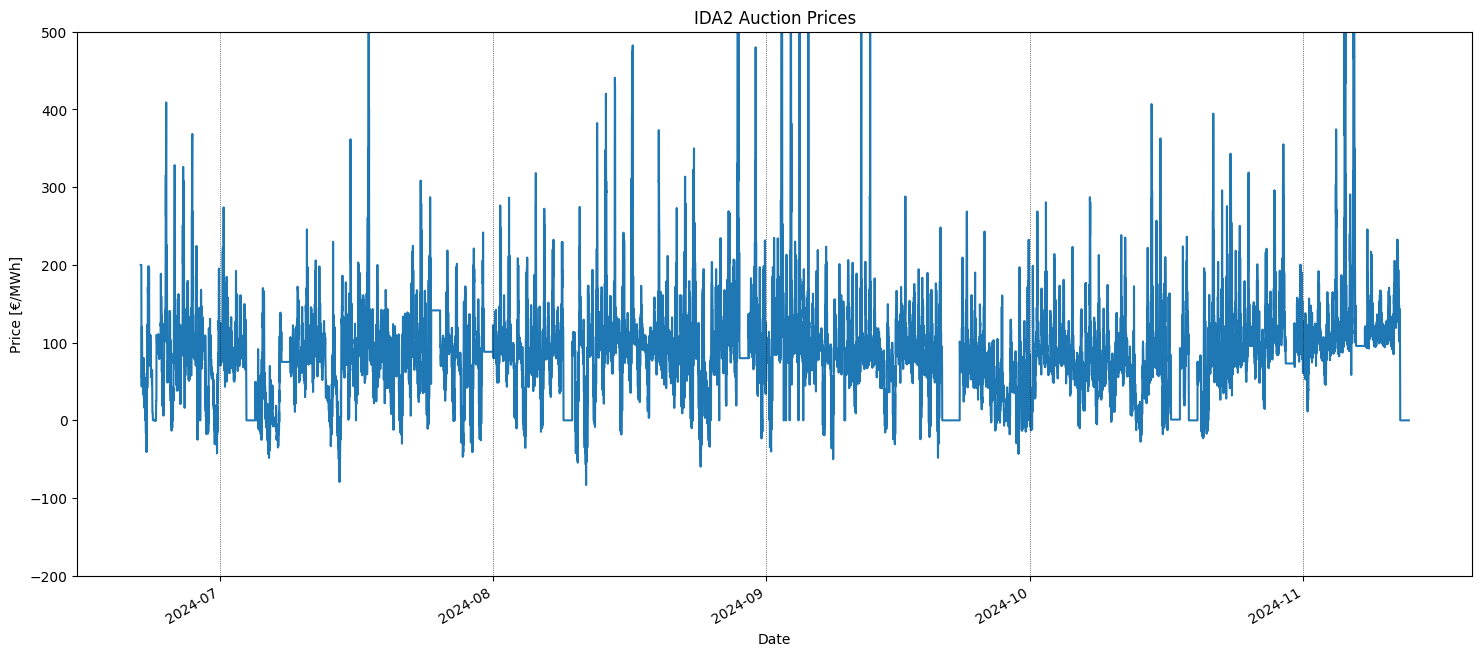

In [10]:
fig, ax = plt.subplots(figsize=(18, 8))
data['IDA2price'].plot(ax=ax)
plt.title('IDA2 Auction Prices')
plt.xlabel('Date')
plt.ylabel('Price [€/MWh]')
for month in range(7, 12):
	plt.axvline(pd.to_datetime('2024-' + str(month) + '-01'), color='k', ls='dotted', lw=0.5)

# plt.axvline(pd.to_datetime('2024-11-02'), color='k', ls='dotted', lw=0.5)
# plt.axvline(pd.to_datetime('2024-10-26'), color='k', ls='dotted', lw=0.5)
# plt.axvline(pd.to_datetime('2024-10-21'), color='k', ls='dotted', lw=0.5)

ax.set_ylim([-200, 500])
plt.show()

In [28]:
print(np.arange(0, 24*4*10, 24*4*10))

[0]


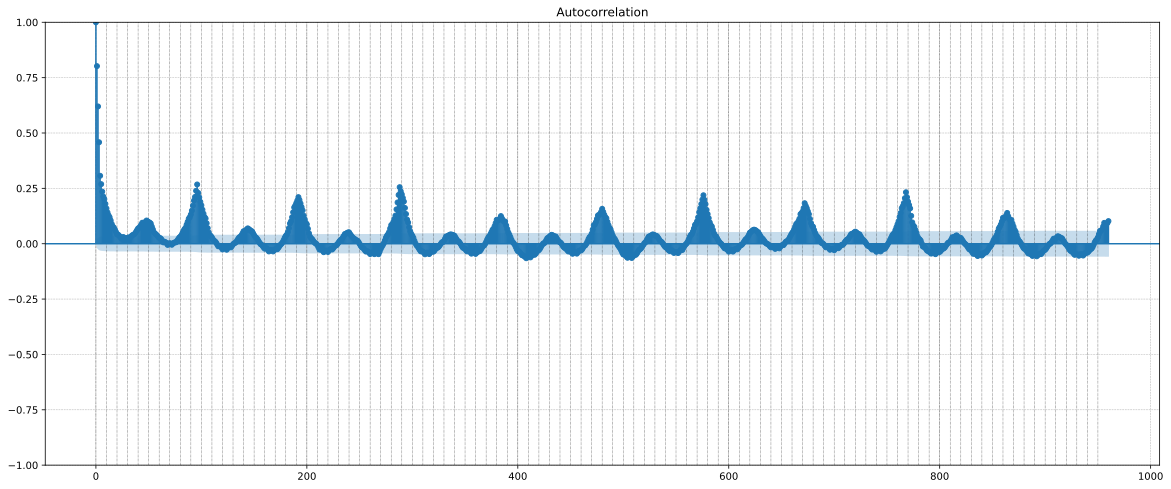

In [50]:
fig, axs = plt.subplots(1, 1, sharex='col', figsize=(20, 8))
axs.grid(linestyle = '--', linewidth = 0.5, which='both')
lines = np.arange(0, 24*4*10, 10)
axs.vlines(x=lines, ymin=-200, ymax=500, color='k', ls='dotted', lw=0.5)

acf_plot = plot_acf(ax = axs, x = data['IDA2price'].dropna(), lags=24*4*10)

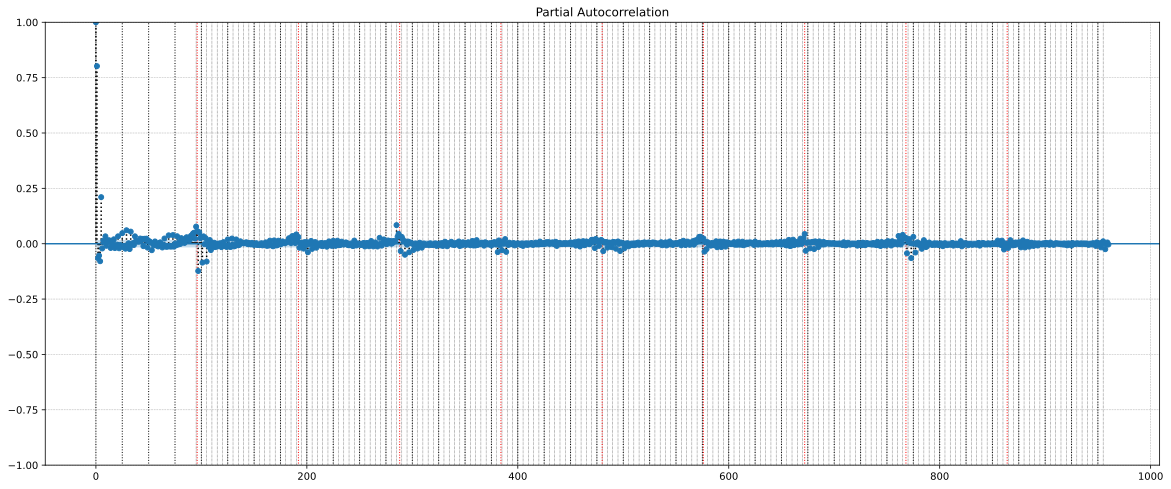

In [60]:
fig, axs = plt.subplots(1, 1, sharex='col', figsize=(20, 8))
axs.grid(linestyle = '--', linewidth = 0.5, which='both')
lines = np.arange(0, 24*4*10, 25)
axs.vlines(x=lines, ymin=-200, ymax=500, color='k', ls='dotted', lw=1)
lines = np.arange(95, 24*4*10, 5)
axs.vlines(x=lines, ymin=-200, ymax=500, color='k', ls='dotted', lw=0.5)
lines = np.arange(96, 24*4*10, 96)
axs.vlines(x=lines, ymin=-200, ymax=500, color='red', ls='dotted', lw=1)

pacf_plot = plot_pacf(ax=axs, x=data['IDA2price'], lags=24*4*10, vlines_kwargs={'colors': 'k', 'linestyles': 'dotted'}, )

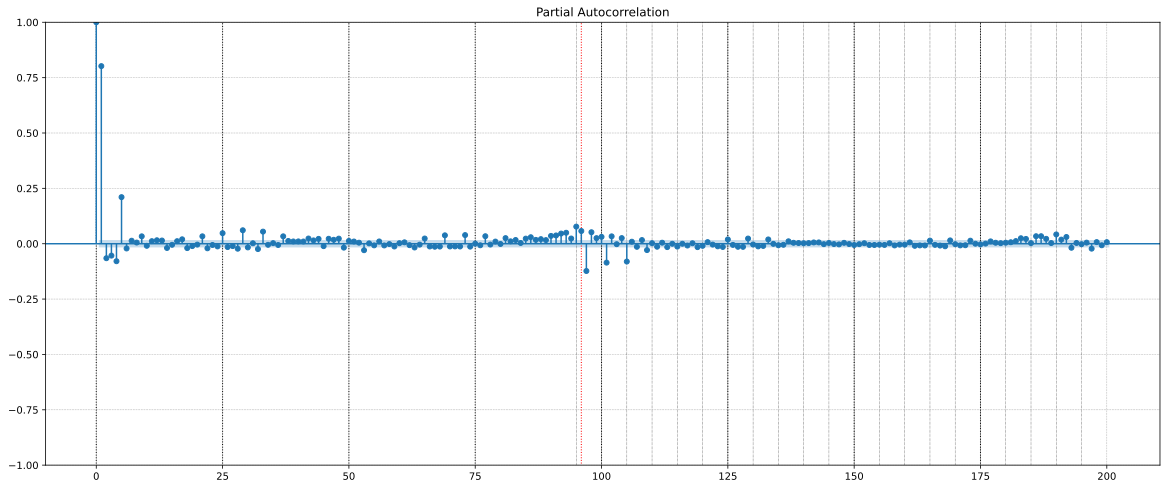

In [57]:
fig, axs = plt.subplots(1, 1, sharex='col', figsize=(20, 8))
axs.grid(linestyle = '--', linewidth = 0.5, which='both')
lines = np.arange(0, 200, 25)
axs.vlines(x=lines, ymin=-200, ymax=500, color='k', ls='dotted', lw=1)
lines = np.arange(95, 200, 5)
axs.vlines(x=lines, ymin=-200, ymax=500, color='k', ls='dotted', lw=0.5)
lines = np.arange(96, 97, 1)
axs.vlines(x=lines, ymin=-200, ymax=500, color='red', ls='dotted', lw=1)

pacf_plot = plot_pacf(ax=axs, x=data['IDA2price'], lags=200)

# lags to include > 96
96, 100, 104, 108
288

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['price_IDA2'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -16.734283
p-value: 0.000000


In [22]:
train, test = df[:-24*4*14], df[-24*4*14:]

In [23]:
train

,price_IDA2,diff_96,diff_1w
date,,,
2024-06-14 00:00,137.90,NaN,NaN
2024-06-14 00:15,113.89,NaN,NaN
2024-06-14 00:30,86.51,NaN,NaN
2024-06-14 00:45,83.80,NaN,NaN
2024-06-14 01:00,78.60,NaN,NaN
...,...,...,...
2024-10-18 21:45,98.75,53.75,16.62
2024-10-18 22:00,126.50,-13.22,24.39
2024-10-18 22:15,96.22,-9.38,-5.14


In [24]:
test

,price_IDA2,diff_96,diff_1w
date,,,
2024-10-18 23:00,111.11,-0.18,5.13
2024-10-18 23:15,94.96,1.57,4.74
2024-10-18 23:30,80.11,20.07,-1.80
2024-10-18 23:45,69.22,34.22,-4.26
2024-10-20 00:00,74.95,-18.05,-28.91
...,...,...,...
2024-11-02 22:45,102.07,22.07,15.26
2024-11-02 23:00,114.78,2.10,-9.78
2024-11-02 23:15,105.99,6.81,-3.30


In [ ]:
da

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Drop rows with NaN values
data = data.dropna()

# Add hour and minute columns
data['Hour'] = data['DeliveryDateTime'].dt.hour
data['Minute'] = data['DeliveryDateTime'].dt.minute
data=data.set_index('DeliveryDateTime')

# Split date on train/test set
split_date = '2024-09-15'  # Change this to your desired date if needed
train_df = data[data.index < split_date]
test_df = data[data.index >= split_date]

X_train = train_df[['Hour', 'Minute','Price_DA']]
y_train = train_df['Price_IDA2']

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Prepare test features
X_test = test_df[['Hour', 'Minute','Price_DA']]

# Make predictions
test_df['Predicted_Price_IDA2'] = model.predict(X_test)


#Analyse results
mae = mean_absolute_error(test_df['Price_IDA2'], test_df['Predicted_Price_IDA2'])

print(f'Mean Absolute Error: {mae}')
test_df[['Predicted_Price_IDA2','Price_IDA2']].plot()

In [32]:
model_fit.summary()

AttributeError: 'numpy.ndarray' object has no attribute 'summary'